<a href="https://colab.research.google.com/github/aliciajnguyen/PokemonMLProjects/blob/main/PokemonGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Resources

GANS
https://medium.com/mlearning-ai/image-generation-using-generative-adversarial-networks-gans-cd82afd71597
https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

Read images from dataset
https://colab.research.google.com/drive/1l227_f3HJ4yGu_DtAkVfrGQZs1UOhQHv?usp=sharing#scrollTo=AYcE5vkJXxRp
https://pillow.readthedocs.io/en/stable/reference/Image.html

#Setup

## Constants and parameters

In [ ]:
height = 28
width = 28
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

BUFFER_SIZE = 60000
BATCH_SIZE = 256


DS_METHOD = "flat_xonly"
#IS_TOY_TEST = True
#path = "./dataset-gen1-3-int" # the path of the dataset parent folder

percentage_test = 10

#path = "./dataset-gen1-3-int" if IS_TOY_TEST is False else "./toydataset151"

# MODEL HYPERPARAMETERS and PARAMETERS
EPOCHS = 240
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

##Imports and Download

In [ ]:
import tensorflow as tf
import keras
from keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

tf.config.run_functions_eagerly(True)

In [ ]:
#dowload actual dataset

from google_drive_downloader import GoogleDriveDownloader as gdd

#labelled folders download
#gdd.download_file_from_google_drive(file_id='1Tc-X02irIo58sRcZbnQ-wp2tcfLvJF23',
#                                    dest_path='./dataset-gen1-3.zip')

#!unzip path_to_file.zip -d path_to_directory
#!unzip './dataset-gen1-3.zip' -d './'

#TOY_TEST
#  gdd.download_file_from_google_drive(file_id='1fBRGe6_O1Xx3KWUFJ6x-3TZ-MJFB_F9H',
#                                      dest_path='./toydataset.zip')
  #https://drive.google.com/file/d/1fBRGe6_O1Xx3KWUFJ6x-3TZ-MJFB_F9H/view?usp=sharing
#  !unzip './toydataset.zip' -d './'

# NESTEED: int named folders download
#gdd.download_file_from_google_drive(file_id='1AJGqOUjZf7gZd55Yxu-VsPTuJ0eVCwRJ',
#                              dest_path='./dataset-gen1-3-int.zip')
#!unzip './dataset-gen1-3-int.zip' -d './'

#FLAT
gdd.download_file_from_google_drive(file_id='1qQcdcJdG8B53gExxExs0cPsgljVWqssa',
                              dest_path='./dataset-gen1-3-flat.zip')

!unzip './dataset-gen1-3-flat.zip' -d './'

TODO - why does the dataset output have 2 different tensor specs??
here:

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
vs mnist:

TensorSpec(shape=(None,), dtype=tf.int32, name=None))

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

look thru:
https://stackoverflow.com/questions/49531286/cannot-batch-tensors-with-different-shapes-in-component-0-with-tf-data-dataset

## Data prepartion: Augmentation

TODO normalize

In [ ]:
# data augmentation

#def augment(x,y):
#  image = tf.image.random_brightness(x,max_delta=0.05)
#  return image, y

#def augment(x):
#  image = tf.image.random_brightness(x,max_delta=0.05)
#  return image

#ds_train = ds_train.map(augment)
#print(ds_train)

## Import data and create dataset

Google tutorial:
https://www.youtube.com/watch?v=q7ZuZ8ZOErE

https://www.youtube.com/watch?v=q7ZuZ8ZOErE&list=PLhhyoLH6IjfxVOdVC1P1L5z5azs0XjMsb&index=18
Linked github:
https://github.com/aladdinpersson/Machine-Learning-Collection#beginner-tutorials
(cust image dataset)

In [ ]:
#import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from keras import layers
#from keras.preprocessing.image import ImageDataGenerator


In [ ]:
#define method to create dataset (how)

# todo elab methods switch statement
def dataset_gengeration_method(ds_method = "flat_xonly"):

  def dataset_directory():
    #Method 1: dataset from directory
    print("current path:", path)
    #TRAIN
    ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels = "inferred",
        label_mode = "int",
        #class_names = ["", ""].
        color_mode="grayscale", #can also be greyscale
        batch_size = BATCH_SIZE,
        image_size = (height, width), #reshape
        shuffle=True, #random order
        seed = 123, #for the shuffle
        validation_split = percentage_test/100,
        subset="training"
    )

    #TEST
    ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels = "inferred",
        label_mode = "int",
        #class_names = ["", ""].
        color_mode="grayscale", #can also be greyscale
        batch_size = BATCH_SIZE,
        image_size = (height, width), #reshape
        shuffle=True, #random order
        seed = 123, #for the shuffle
        validation_split = percentage_test/100,
        subset="validation" #aka test
        #dtype = tf.float32
    )

    #print(type(ds_validation))
    #print(ds_validation)


  def dataset_generator():
    # Method 2: imageDataGenertor and flow_from_directory
    # specify how we want the data to be processed
    datagen = ImageDataGenerator(
        rescale = 1./255, #ensure float, to normalize
        #rotation_range = 5,
        # can spec a BUNCH of data aug here INCL RESCALE
        #zoom_range = (0.95, 0.95) ,
        #horizontal_flip = False,
        #vertical_flip = False,
        data_format = "channels_last",
        validation_split = 0.0,
        dtype = tf.float32
    )

    #actually deal w data
    #currently doing without train/test split
    train_generator = datagen.flow_from_directory(
        path, # if in folders can change here?
        target_size =  (height, width),
        batch_size = BATCH_SIZE,
        color_mode = "rgb",
        class_mode="sparse", #want it to be in int representing rather that one hot
        shuffle= True,
        subset="training",
        seed = 123
    )


  def dataset_flat():
    # method3 : all in 1 folder
    import pathlib # bc this is format  list_files() wants

    directory = "toydataset151/"
    ds_train = tf.data.Dataset.list_files(str(pathlib.Path(directory+'*.png')))

    #define a process, given the file path, process image
    def process_path(file_path):
      image = tf.io.read_file(file_path)
      image = tf.image.decode_png(image, channels=1)
      image = tf.image.resize(image, [width, height])

      label = tf.strings.split(file_path, '.') #just using file name, only numeral.ong
      label = tf.strings.substr(label, pos=0, len=1)[0]      #cats, dogs, horses
      label = tf.strings.to_number(label, out_type=tf.int64)
      return image, label

    ds_train = ds_train.map(process_path).batch(BATCH_SIZE)

    #attempt to extr
    ds_train = ds_train.map(lambda images, labels: images)
    print(ds_train)

    return ds_train

  def dataset_flat_xonly():
    #Method 4: custom 1 folder no labels
    import pathlib # bc this is format  list_files() wants

    directory = "/content/dataset-gen1-3-flat/"
    ds_train = tf.data.Dataset.list_files(str(pathlib.Path(directory+'*.png')))
    print(ds_train)

    def process_path(file_path):
      image = tf.io.read_file(file_path)
      image = tf.image.decode_png(image, channels=1)
      image = tf.image.resize(image, [width, height])
      #TODO augment here
      image = (image - 127.5) /127.5
      (image - 127.5) / 127.5 # Normalize the images to [-1, 1]

      return image

    ds_train = ds_train.map(process_path).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    print(ds_train)
    return ds_train

  def dataset_flat_aug():
    #Method 4: custom 1 folder no labels
    import pathlib # bc this is format  list_files() wants

    directory = "/content/dataset-gen1-3-flat/"
    ds_train = tf.data.Dataset.list_files(str(pathlib.Path(directory+'*.png')))
    print(ds_train)

    def process_path(file_path):
      image = tf.io.read_file(file_path)
      image = tf.image.decode_png(image, channels=1)
      image = tf.image.resize(image, [width, height])
      #TODO augment here
      #image = (image - 127.5) /127.5
      #(train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

      return image

    ds_train = ds_train.map(process_path).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    #ds_train = tf.data.Dataset.from_tensor_slices(ds_train.map(process_path)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    print(ds_train)
    return ds_train

  if ds_method == "flat_xonly":
    return dataset_flat_xonly()
  elif ds_method == "flat_aug":
    return dataset_flat_aug()
  else:
    print("u asked for dataset gen u havent finished implemneting")

In [ ]:
# actually prepare datset
ds_train = dataset_gengeration_method(ds_method = DS_METHOD)

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


### Original MNIST load

In [ ]:
# from tutorial

# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# I think train_images is just an numpy array? YES UGH
# ?? I think there's an error in the above line bc should return:
# (x_train, y_train), (x_test, y_test).
print(type(train_images))
print(train_images.shape)

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print(type(train_images))
print(train_images.shape)


BUFFER_SIZE = 60000
#BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<class 'numpy.ndarray'>
(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)
<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


#Model

## Generator Network

In [ ]:
# Model

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

### Sample Creator

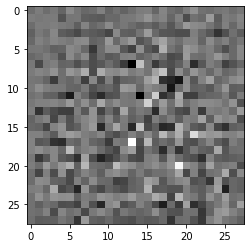

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

##Discriminator Network

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
#we can check what our non-trained discriminator says about the sample generated by the non-trained generator:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00190668]], shape=(1, 1), dtype=float32)


## Loss Functions and Optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpoints

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Train the Model

In [ ]:
#model hyperparameters centralized

#EPOCHS = 120
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
#num_examples_to_generate = 16
#noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Defining the train step

In [ ]:
# tf.function annotation causes the function
# to be "compiled" as part of the training
@tf.function
def train_step(images):

    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using
    # operations recorded in context of this tape (gen_tape and disc_tape).

    # It accepts a target (e.g., gen_loss) variable and
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors
    # (or IndexedSlices, or None), one for each element in sources.
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients.
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

###Defining the Train Loop

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch,
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### Image Generation Function

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  #print("test_input is:", test_input)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Start training

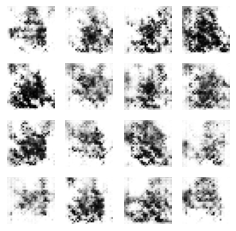

In [ ]:
#train(train_dataset, EPOCHS)
#print(ds_train)
train(ds_train, EPOCHS)

### Generate Digits

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

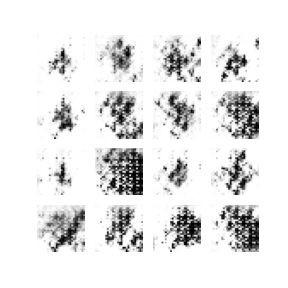

In [ ]:
# PIL is a library which may open different image file formats
import PIL
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

# Gif visualizing evolution

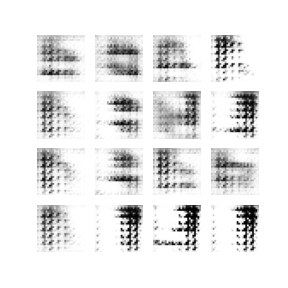

In [ ]:
import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)

display.Image(open('dcgan.gif','rb').read())

#Discard

cust dataset attempt

https://medium.com/analytics-vidhya/create-tensorflow-image-classification-model-with-your-own-dataset-in-google-colab-63e9d7853a3e
https://www.tensorflow.org/guide/data <<< background

In [ ]:
##FUCUUCK

#!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow
!pip install tensorflow_hub

from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

pd.set_option("display.precision", 8) #precision?

data_root='./toydataset/toydataset151'

#create data generator for training and validation
IMAGE_SHAPE = (40, 40)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR)#;
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR,subset="validation",
    shuffle=True,
    target_size=IMAGE_SHAPE)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                    subset="training",
                                                    shuffle=True,
                                                    target_size=IMAGE_SHAPE)

#learn about batches
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(),
                        key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

In [ ]:
## to use dataset:

#To use the new dataset with tfds.load('my_dataset'):
#    tfds.load will automatically detect and load the dataset generated in ~/tensorflow_datasets/my_dataset/ (e.g. by tfds build).


In [ ]:
#CREATE tensorflow dataset




#LOAD
# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# try creatign tensor flow dataset obj by loading np arrays
# STOP DOING THINGS SO MANUALLY USE API

from PIL import Image
import numpy as np

count = 0

#first one to append to therefater
#pil_img = Image.open("./dataset-gen1-3-int/0/1.png")
#pil_img_resize = pil_img.resize((height, width))
#Xtrain = np.array(pil_img_resize)

Xtrain = np.empty(4711)
print(Xtrain.shape)

# 0...6 = 151 (gen1), 7...12 = 251(gen2),  13-20 = 386
for i in range(0,20+1):
  max = 151 if i < 7 or i >= 17 else (386 if i > 12 else 251) # not what we thought for gen3 srites
  for j in range(1, max+1):
    path = f"./dataset-gen1-3-int/{i}/{j}.png"
    pil_img = Image.open(path)
    pil_img_resize = pil_img.resize((height, width))
    im_array = np.array(pil_img_resize)
    #Xtrain[count] = im_array
    np.put(Xtrain, count, im_array) #, mode='raise'
    #Xtrain = np.append(Xtrain, im_array, axis = 1)
    count+= 1


    #print('Pixel type:', im_resize.dtype)
    #print('Number of dimensions:', im_resize.ndim)
    #print('Image size:', im_resize.shape)
    #pil_img_resize

print("count:", count)
print(Xtrain.shape)

# FROM dataset obj - can we reshape it? seems like no
#tf.reshape(    tensor, shape, name=None)

tf.reshape(
    train_dataset, (5795, 28, 28), name=None
)


##TESTS: Dataloading toydataset to numpyarrays

Assistance from: https://medium.com/de-bijenkorf-techblog/image-vector-representations-an-overview-of-ways-to-search-visually-similar-images-3f5729e72d07

##Test reading a single image


In [ ]:

# Google drive download
from google_drive_downloader import GoogleDriveDownloader as gdd

#TEST download file from google drive
gdd.download_file_from_google_drive(file_id='1qKT4MvajyBy6MNbj7H_qzLJLpMTOq6IW',
                                    dest_path='./test.png')

gdd.download_file_from_google_drive(file_id='1fBRGe6_O1Xx3KWUFJ6x-3TZ-MJFB_F9H',
                                    dest_path='./')

#https://drive.google.com/file/d/1fBRGe6_O1Xx3KWUFJ6x-3TZ-MJFB_F9H/view?usp=sharing

#!unzip path_to_file.zip -d path_to_directory
!unzip './toydataset151.zip' -d './toydataset/'


In [ ]:
#Sample: reading, resizing and loading a single instance to numpy array

from PIL import Image
import numpy as np

pil_img = Image.open('./toydataset/toydataset151/1.png')

#Image.resize(size, resample=None, box=None, reducing_gap=None)

pil_img_resize = pil_img.resize((48, 48))

# look at original
im = np.array(pil_img)
print('Pixel type:', im.dtype)
print('Number of dimensions:', im.ndim)
print('Image size:', im.shape)
pil_img

# look at resize
im_resize = np.array(pil_img_resize)
print('Pixel type:', im_resize.dtype)
print('Number of dimensions:', im_resize.ndim)
print('Image size:', im_resize.shape)
pil_img_resize

In [ ]:
#Read and resize toy dataset
#For now we'll flatten each image to a 1D image vector for simplicity in understanding shape


from PIL import Image
import numpy as np

instances_num = 151 #toy only

#we'll create the first array
path = f'./toydataset/toydataset151/1.png'
pil_img = Image.open(path)
pil_img_resize = pil_img.resize((48, 48))
img_array = np.array(pil_img_resize)
print(img_array.shape)
X=img_array.flatten()
print(X.shape)

#now concat the rest
for i in range (2,instances+1):
  path = f'./toydataset/toydataset151/{i}.png'
  pil_img = Image.open(path)
  pil_img_resize = pil_img.resize((48, 48))

  img_array = np.array(pil_img_resize)
  img_array = img_array.flatten()
  X = np.vstack([X, img_array])

print(X.shape)

#Now split X into test and train
import math

percentage_train = 80
thresh = math.floor(instances_num* (percentage_train/100))

Xtrain = X[: thresh ]
Xtest = X[thresh:]

print(Xtrain.shape)
print(Xtest.shape)